# HELLO!

$ x + 1 $

In [1]:
from magnum import Vector3

In [2]:
%%capture
import os
import quaternion
import habitat_sim.sim
import numpy as np
from scipy.io import wavfile


# os.chdir('/home/e4e-student/soundspaces/habitat-sim')
backend_cfg = habitat_sim.SimulatorConfiguration()
backend_cfg.scene_id = "/workspace/data/custom_data/4Cubes2/4Cubes2.basis.glb"
# IMPORTANT: missing this file will lead to load the semantic scene incorrectly
backend_cfg.scene_dataset_config_file = "/workspace/data/custom_data/hm3d_annotated_basis.scene_dataset_config.json"

backend_cfg.load_semantic_mesh = True
backend_cfg.enable_physics = False

agent_config = habitat_sim.AgentConfiguration()

cfg = habitat_sim.Configuration(backend_cfg, [agent_config])
sim = habitat_sim.Simulator(cfg)

# set navmesh path for searching for navigable points
# if dataset == 'mp3d':
#     sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/forests/test/forest.navmesh"))
# else:
#     sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/gibson/Oyens.navmesh"))

# create the acoustic configs
acoustics_config = habitat_sim.sensor.RLRAudioPropagationConfiguration()
acoustics_config.enableMaterials = True

# create channel layout
channel_layout = habitat_sim.sensor.RLRAudioPropagationChannelLayout()
channel_layout.channelType = (
    habitat_sim.sensor.RLRAudioPropagationChannelLayoutType.Mono
)
channel_layout.channelCount = 2

        # create the Audio sensor specs, assign the acoustics_config and the channel_layout.
        # note that the outputDirectory should already exist for each iteration step.
        # for the example below, folders /home/AudioSimulation0, /home/AudioSimulation1 ... should
        # exist based on the number of iterations
audio_sensor_spec = habitat_sim.AudioSensorSpec()
audio_sensor_spec.uuid = "audio_sensor"
audio_sensor_spec.outputDirectory = "/tmp/AudioSimulation"
audio_sensor_spec.acousticsConfig = acoustics_config
audio_sensor_spec.channelLayout = channel_layout

audio_sensor_spec.position = [0.0, 1.5, 0.0]  # audio sensor has a height of 1.5m
audio_sensor_spec.acousticsConfig.sampleRate = 48000
# whether indrect (reverberation) is present in the rendered IR
audio_sensor_spec.acousticsConfig.indirect = True

# add the audio sensor
sim.add_sensor(audio_sensor_spec)

# Get the audio sensor object
audio_sensor = sim.get_agent(0)._sensors["audio_sensor"]

# set audio source location, no need to set the agent location, will be set implicitly
audio_sensor.setAudioSourceTransform(np.array([3.1035, 1.57245, -4.15972]))

# optionally, set the audio materials json
audio_sensor.setAudioMaterialsJSON("/workspace/data/mp3d_material_config.json")

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[21:16:02:839759]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hm3d_annotated_basis' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


In [3]:
# # recompute nav mesh
# navmesh_settings = habitat_sim.NavMeshSettings()
# # use_custom_settings = True
# # sim.navmesh_visualization = False
# navmesh_settings.set_defaults()
# navmesh_success = sim.recompute_navmesh(
#   sim.pathfinder, navmesh_settings
# )

# if not navmesh_success: 
#   print("Failed to build navmesh!")
# if sim.pathfinder.is_loaded:
#   navmesh_save_path = "/workspace/data/custom_data/test.navmesh" #@param {type:"string"}
#   sim.pathfinder.save_nav_mesh(navmesh_save_path)
#   print('Saved NavMesh to "' + navmesh_save_path + '"')
#   sim.pathfinder.load_nav_mesh(navmesh_save_path)

In [4]:
# sampled navigable point is on the floor
source_pos = Vector3(0,0,0) #Vector3(0,0,0)#
# source_pos = sim.pathfinder.get_random_navigable_point()
# print('Sample source location: ', source_pos)

In [5]:
height = Vector3(0,5,0)
agent_pos = Vector3(0,0,0)

In [6]:
audio_sensor.setAudioSourceTransform(source_pos + height) # add 1.5m to the height calculation 
agent = sim.get_agent(0)
new_state = sim.get_agent(0).get_state()
new_state.position = source_pos + agent_pos
new_state.sensor_states = {}
agent.set_state(new_state, True)
ir = np.array(sim.get_sensor_observations()["audio_sensor"]) 
#print(ir.shape)

# once a category is not found in the material mapping file, the default acoustic material will be used.

CreateContext: Context created


In [7]:
# This bit of code crashes. Unsure why, trying to review this
#sim.get_sensor_observations()

In [8]:
# check if the direct sound is present (source is visibile from the listener)
#audio_sensor.sourceIsVisible()
# Note this does not appear to exist in newer habitat sim...

In [9]:
# check the efficiency of rendering, outdoor would have a very low value, e.g. < 0.05, 
# while a closed indoor room would have >0.95, and a room with some holes might be in the 0.1-0.8 range.
# if the ray efficiency is low for an indoor environment, it indicates a lot of ray leak from holes
# you should repair the mesh in this case for more accurate acoustic rendering
# audio_sensor.getRayEfficiency()
# Note this does not appear to exist in newer habitat sim...

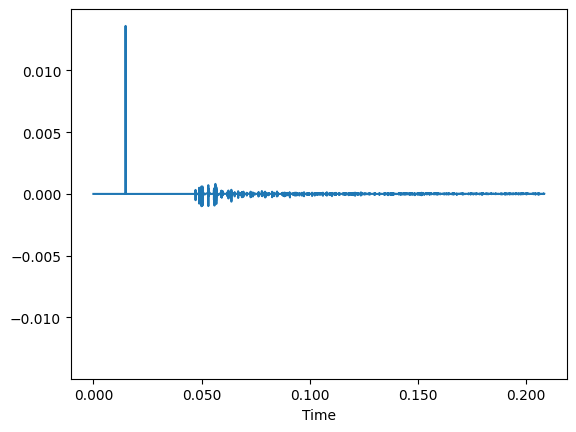

In [10]:
# plot the waveform of IR and show the audio
from librosa.display import waveshow, specshow
import IPython
waveshow(ir[0, :10000], sr=48000)
IPython.display.Audio(ir, rate=48000)

In [11]:
#!pip install librosa

In [12]:
# one example for how to use IR data to get the reverberant speech
import librosa
#sr, vocal = wavfile.read('res/singing.wav')
vocal, sr = librosa.load(path="/workspace/XC150592 - Screaming Piha - Lipaugus vociferans.mp3")
print(sr, vocal.shape)
IPython.display.Audio(vocal, rate=sr)

22050 (73152,)


In [13]:
from scipy.signal import fftconvolve

# convolve the vocal with IR
convolved_vocal = np.array([fftconvolve(vocal, ir_channel) for ir_channel in ir]) 
IPython.display.Audio(convolved_vocal, rate=sr)

In [14]:
convolved_vocal.shape, vocal.shape

((1, 291857), (73152,))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = vocal
y_ = convolved_vocal

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
D_ = librosa.amplitude_to_db(np.abs(librosa.stft(y_.mean(axis=0))), ref=np.max)

img = librosa.display.specshow(D, y_axis='linear', x_axis='time',

                               sr=sr, ax=ax[0])

img = librosa.display.specshow(D_, y_axis='linear', x_axis='time',

                               sr=sr, ax=ax[1])

ax[0].set(title='Linear-frequency power spectrogram')

ax[0].label_outer()

In [ ]:
import matplotlib.pyplot as plt

y, sr = librosa.load(librosa.ex('choice'), duration=15)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

img = librosa.display.specshow(D, y_axis='linear', x_axis='time',

                               sr=sr, ax=ax[0])

ax[0].set(title='Linear-frequency power spectrogram')

ax[0].label_outer()

In [ ]:
# from pyroomacoustics.experimental.rt60 import measure_rt60

# rt60 = measure_rt60(ir[0], sr, decay_db=30, plot=True)
# print(f'RT60 of the rendered IR is {rt60:.4f} seconds')